# Reading from a CSV

## Install

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /


✅ The installed version of syft==0.8.1b9 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-1", port=9081, reset=True)

Starting pandas-test-domain-1 server on 0.0.0.0:9081


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /


Waiting for server to start..SQLite Store Path:
!open file:///var/folders/f1/h55w4kj150x0s8c3jwhkkygw0000gn/T/f738b00d76064071858e9baf688c0d3f.sqlite

. Done.


# Data owner: Upload data

In [4]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

## Load data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from pandas._libs.tslibs.timestamps import Timestamp
from syft import autocache
from syft.util.util import PANDAS_DATA

In [6]:
data_path = autocache(f"{PANDAS_DATA}/bikes.csv", cache=False)

HERE!
filename bikes.csv
filename in FILE_TO_TESTFILE


In [7]:
broken_df = pd.read_csv(data_path, encoding = "ISO-8859-1")

In [8]:
broken_df

,Date;Berri 1;Brï¿½beuf (donnï¿½es non disponibles);Cï¿½te-Sainte-Catherine;Maisonneuve 1;Maisonneuve 2;du Parc;Pierre-Dupuy;Rachel1;St-Urbain (donnï¿½es non disponibles)
0,01/01/2012;35;;0;38;51;26;10;16;
1,02/01/2012;83;;1;68;153;53;6;43;
2,03/01/2012;135;;2;104;248;89;3;58;
3,04/01/2012;144;;1;116;318;111;8;61;
4,05/01/2012;197;;2;124;330;97;13;95;
...,...
94,04/04/2012;2211;;933;1674;2956;1666;274;2242
95,05/04/2012;2424;;1036;1823;3273;1699;355;2463
96,06/04/2012;1633;;650;1045;1913;975;621;2138
97,07/04/2012;1208;;494;739;1445;709;598;1566


In [ ]:
assert len(broken_df) == 310

In [ ]:
fixed_df = pd.read_csv(data_path, sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
fixed_df[:3]

,Berri 1,Brï¿½beuf (donnï¿½es non disponibles),Cï¿½te-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (donnï¿½es non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN


In [ ]:
assert len(fixed_df) == 310

In [ ]:
import numpy as np
from random import randint

def get_mock_int(i, var=10):
    base = 100 + int(np.cos(i/10) * 50)
    return randint(max(base-var, 1),max(1, base+var))

def get_mock_date(i):
    return str(parse('Jun 1 2005').date() + timedelta(days=i))

# some randomness
r = [(randint(1, 40), randint(1, 40)) for _ in range(7)]

def get_mock_row(i):
    res = [get_mock_int(i+r[j][0], r[j][1]) for j in range(7)]
    # add NaNs in the second and 10th col
    res.insert(1, None), res.insert(9, None)
    return res
    

In [11]:
mock = pd.DataFrame(index=[Timestamp(get_mock_date(i)) for i in range(len(fixed_df))],
                    data=[get_mock_row(i) for i in range(len(fixed_df))],
                    columns=fixed_df.columns)

Upload the data

In [12]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="bikes", data=fixed_df, mock=mock, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Uploading: bikes


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## Create user account

In [13]:
user = root_domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

In [14]:
# todo: give user data scientist role

In [15]:
guest_domain_client = node.client

In [16]:
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: request execution

## Download mock and submit a syft_function

### Get mock

In [17]:
guest_domain_client = node.client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [18]:
ds = guest_domain_client.datasets[0]

In [19]:
asset = ds.assets["bikes"]

In [20]:
df = asset.mock

### Selecting a column

When you read a CSV, you get a kind of object called a DataFrame, which is made up of rows and columns. You get columns out of a DataFrame the same way you get elements out of a dictionary.

Here's an example:

In [21]:
df['Berri 1']

```python
TwinPointer(Mock)
```
2005-06-01     52
2005-06-02     46
2005-06-03     46
2005-06-04     49
2005-06-05     53
             ... 
2005-09-03    149
2005-09-04    144
2005-09-05    151
2005-09-06    150
2005-09-07    146
Name: Berri 1, Length: 99, dtype: int64

### Plotting a column

Just add .plot() to the end! How could it be easier? =)

We can see that, unsurprisingly, not many people are biking in January, February, and March,

<Axes: >

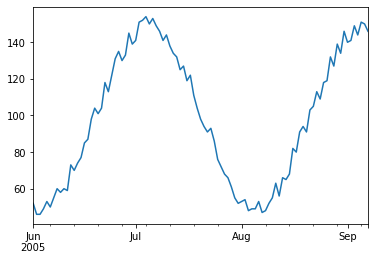

In [22]:
df['Berri 1'].plot()

We can also plot all the columns just as easily. We'll make it a little bigger, too. You can see that it's more squished together, but all the bike paths behave basically the same -- if it's a bad day for cyclists, it's a bad day everywhere.

<Axes: >

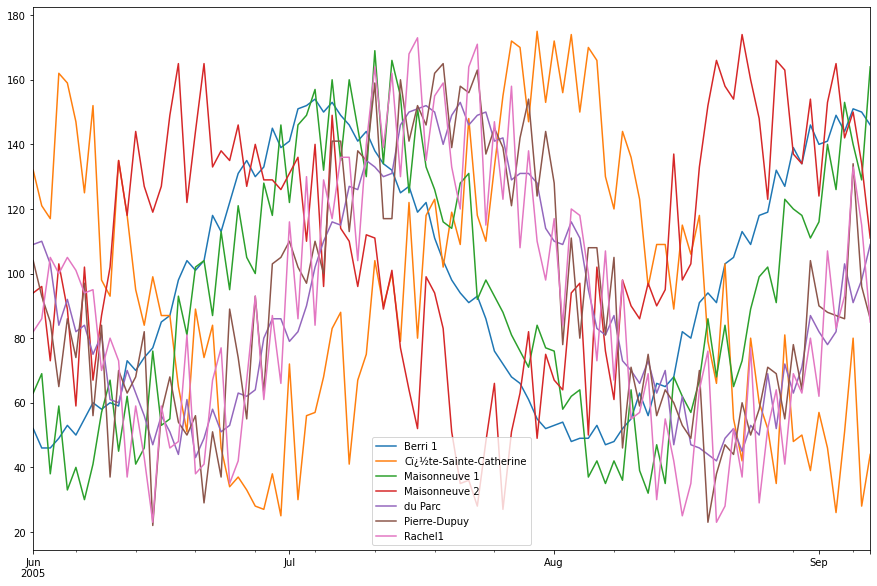

In [23]:
df.plot(figsize=(15, 10))

### Putting that all together

Here's the code we needed to write do draw that graph, all together:



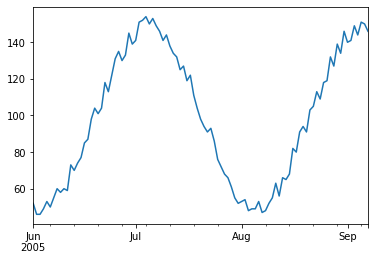

In [24]:
res = df['Berri 1'].plot()

In [25]:
@sy.syft_function(input_policy=sy.ExactMatch(df=asset.pointer),
                  output_policy=sy.SingleExecutionExactOutput())
def get_column(df):
    return df['Berri 1']

Create and submit project

In [26]:
new_project = sy.Project(
    name="My pandas project 1",
    description="Hi, I would like to plot the Berri 1 column.",
    members=[guest_domain_client],
)
new_project

```python
class ProjectSubmit:
  id: str = 2906393b6be64c5ea7a9d69c529286e6
  name: str = "My pandas project 1"
  description: str = "Hi, I would like to plot the Berri 1 column."
  created_by: str = "jane@caltech.edu"

```

In [27]:
project = new_project.start()
assert isinstance(project, sy.service.project.project.Project)
project

```python
class Project:
  id: str = 2906393b6be64c5ea7a9d69c529286e6
  name: str = "My pandas project 1"
  description: str = "Hi, I would like to plot the Berri 1 column."
  created_by: str = "jane@caltech.edu"
  events: str = []

```

In [28]:
project.create_code_request(get_column, guest_domain_client)

<class 'syft.service.response.SyftSuccess'>: Request added successfully

In [29]:
assert len(guest_domain_client.code.get_all())==1

In [30]:
assert len(project.events) == 1

In [31]:
assert isinstance(project.events[0], sy.service.project.project.ProjectRequest)

# Data owner: execute function

## Get messages

In [32]:
domain_client = node.client.login(email="info@openmined.org", password="changethis")

In [33]:
messages = domain_client.api.services.messages.get_all_unread()

In [34]:
messages

[syft.service.message.messages.Message, syft.service.message.messages.Message]

In [35]:
from syft.service.project.project import Project

In [36]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]
project_message

```python
class Message:
  id: str = 80b649c2235247c88af5c04c9b549631
  subject: str = "A new request has been added to the Project: My pandas project 1."
  status: str = MessageStatus.UNREAD
  created_at: str = 2023-06-14 17:22:02
  linked_obj: str = <<class 'syft.service.project.project.Project'>: 2906393b6be64c5ea7a9d69c529286e6@<Node: f738b00d76064071858e9baf688c0d3f>

```

In [37]:
request = project_message.link.events[0].request

In [38]:
func = request.changes[0].link
op = func.output_policy_type

In [39]:
func

```python
class UserCode:
  id: str = 911e1d2aa8db4a2db17e8a55521213ba
  status.approved: str = "<Missing>"
  service_func_name: str = "get_column"

```

In [40]:
get_col_user_function = func.unsafe_function

In [41]:
real_data = domain_client.datasets[0].assets[0].data

In [42]:
real_result = get_col_user_function(df=real_data)

In [43]:
real_result[:3]

Date
2012-01-01     35
2012-01-02     83
2012-01-03    135
Name: Berri 1, dtype: int64

In [44]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [45]:
asset = guest_client.datasets[0].assets[0]

In [46]:
guest_client.code[0].status

{NodeView(node_name='pandas-test-domain-1', verify_key=dc9b0f3b23002afc3da1da6d362ad6ef9f47f2bf70df65227b57a11f1f47c992): <UserCodeStatus.EXECUTE: 'execute'>}

In [47]:
result_ptr = guest_client.code.get_column(df=asset)

<Axes: >

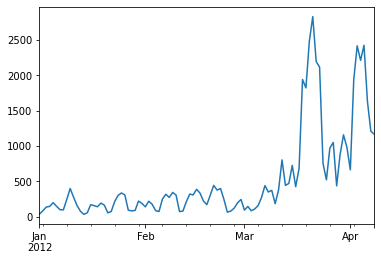

In [48]:
real_result = result_ptr.get_from(guest_client)
real_result.plot()

In [49]:
node.land()

Stopping pandas-test-domain-1
